In [ ]:
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image.image_data_generator import ImageDataGenerator
from tensorflow.keras import Model,Sequential
from tensorflow.keras import layers
from keras import models
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
import cv2
import shutil

In [ ]:
print(tf.__file__)

/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py


In [ ]:
with open('/content/drive/My Drive/ML_Project/img_dt_gnrtr.py','r') as writer_file:
    contents_to_write = writer_file.read()

with open('/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py','w') as file_to_overwrite:
    file_to_overwrite.write(contents_to_write)

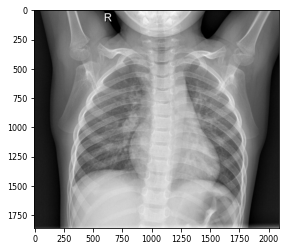

In [ ]:
TRAIN = '/content/drive/My Drive/ML_Project/TRAIN'
#VAL = '/content/drive/My Drive/x_ray/chest_xray/val'
TEST = '/content/drive/My Drive/ML_Project/TEST'
img = cv2.imread('/content/drive/My Drive/ML_Project/TRAIN/NORMAL/IM-0115-0001.jpeg') 
plt.imshow(img)


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You c

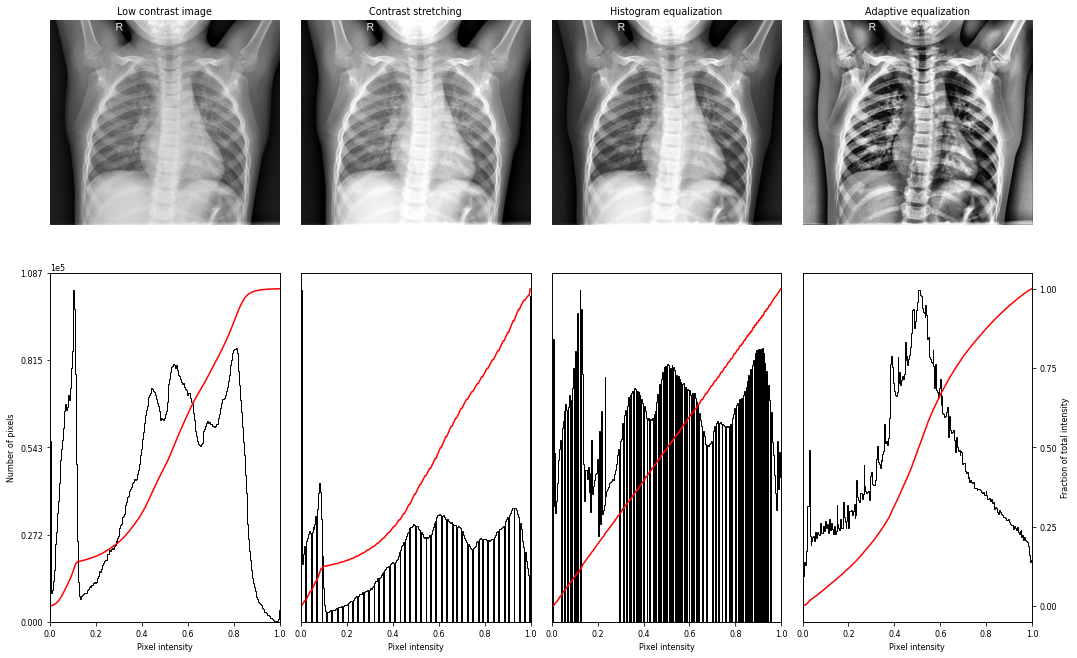

In [ ]:
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure

def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf
# Load an example image from cifar10 dataset
#img = images[0]

# Set font size for images
matplotlib.rcParams['font.size'] = 8

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Histogram Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

#### Everything below here is just to create the plot/graphs ####

# Display results
fig = plt.figure(figsize=(15, 10)) 
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)
    
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()


In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = "imagenet")

#pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('block1_conv2')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 224, 224, 64)


In [ ]:
TRAINING_DIR = TRAIN
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 30,
    shear_range = 0.2,
    zoom_range = 0.3,
    brightness_range = (0.7,1.3),
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    TRAIN,
    batch_size = 32,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224,224)
)

validation_datagen = ImageDataGenerator(
    rescale = 1.0/255.0
)

validation_generator = validation_datagen.flow_from_directory(
    TEST,
    batch_size = 32,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224,224)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    TEST,
    shuffle=True,
    batch_size = 32,
    class_mode = 'binary',
    target_size = (224,224)
)

Found 5286 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
x  =  layers.AveragePooling2D((2,2))(last_output)

x  =  layers.BatchNormalization()(x)
x  =  layers.Conv2D(32,(3,3),padding = "same",activation = "relu")(x)
x  =  layers.AveragePooling2D((2,2))(x)

x  =  layers.BatchNormalization()(x)
x  =  layers.Conv2D(64,(3,3),padding = "same",activation = "relu")(x)
x  =  layers.AveragePooling2D((2,2))(x)

x  =  layers.BatchNormalization()(x)
x  =  layers.Conv2D(64,(3,3),padding = "same",activation = "relu")(x)
x  =  layers.AveragePooling2D((2,2))(x)

x  =  layers.BatchNormalization()(x)
x  =  layers.Conv2D(128,(3,3),padding = "same",activation = "relu")(x)
x  =  layers.AveragePooling2D((2,2))(x)

x  =  layers.BatchNormalization()(x)
x  =  layers.Conv2D(256,(3,3),padding = "same",activation="relu")(x)
x  =  layers.AveragePooling2D((2,2))(x)

x  =  layers.BatchNormalization()(x)
x  =  layers.Conv2D(512,(3,3),padding = "same",activation="relu")(x)
x  =  layers.AveragePooling2D((2,2))(x)

x  =  layers.Flatten()(x)

x  =  layers.Dense(512,activation = "relu")(x)
x  =  layers.Dropout(0.7)(x)
x  =  layers.Dense(512,activation = "relu")(x)
x  =  layers.Dropout(0.5)(x)
x  =  layers.Dense(1,activation = "sigmoid")(x)


model = Model( pre_trained_model.input, x)
op = Adam(lr=1e-3)	
model.compile(optimizer=op, loss='binary_crossentropy', metrics=['acc'])

model.summary()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.97):
      print("\nReached 94% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      18464     
_________________________________________________________________
average_pooling2d_1 (Average (None, 56, 56, 32)       

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,  
    epochs = 100,
    verbose = 1,
    steps_per_epoch = 5216/32,  
    callbacks = [callbacks]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
163/163 [==============================] - 3281s 20s/step - loss: 0.3953 - acc: 0.8283 - val_loss: 4.2022 - val_acc: 0.6250
Epoch 2/100
163/163 [==============================] - 173s 1s/step - loss: 0.3235 - acc: 0.8680 - val_loss: 0.4070 - val_acc: 0.8061
Epoch 3/100
163/163 [==============================] - 136s 833ms/step - loss: 0.2546 - acc: 0.8985 - val_loss: 0.2966 - val_acc: 0.8942
Epoch 4/100
163/163 [==============================] - 136s 834ms/step - loss: 0.2433 - acc: 0.9071 - val_loss: 0.2763 - val_acc: 0.8910
Epoch 5/100
163/163 [==============================] - 135s 831ms/step - loss: 0.2217 - acc: 0.9106 - val_loss: 0.3648 - val_acc: 0.8590
Epoch 6/100
163/163 [==============================] - 137s 842ms/step - loss: 0.2153 - acc: 0.9160 - val_loss: 0.9326 - val_acc: 0.6426
Epoch 7/100
163/163 [==============================] - 137s 841ms/step - loss: 0.2026 - acc: 0.9268 - val_

In [ ]:
 model.evaluate_generator(test_generator,verbose=1)

20/20 [==============================] - 6s 298ms/step - loss: 0.4048 - acc: 0.9263


[0.4047679305076599, 0.9262820482254028]

Text(0.5, 1.0, 'Training and validation loss')

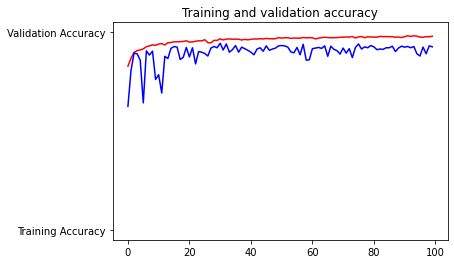

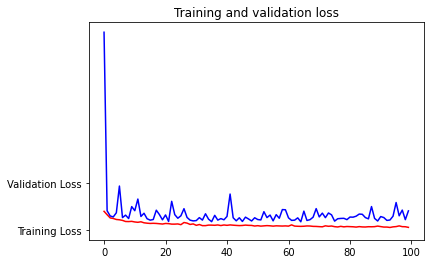

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
 

acc=history.history['acc']
val_acc=history.history['val_acc'] 
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
  

plt.title('Training and validation loss')


In [ ]:
model.save('/content/drive/My Drive/ML_Project/97.h5')

NameError: ignored

In [ ]:
 new_model = tf.keras.models.load_model('/content/drive/My Drive/ML_Project/94.h5')

In [ ]:
new_model.evaluate_generator(test_generator,verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
 4/20 [=====>........................] - ETA: 4:03 - loss: 0.2958 - acc: 0.9453

KeyboardInterrupt: ignored

In [ ]:
layer_outputs = [layer.output for layer in new_model.layers[:20]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=new_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/drive/My Drive/ML_Project/TRAIN/NORMAL/IM-0115-0001.jpeg', target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
activations = activation_model.predict(image)

In [ ]:
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(1, 224, 224, 64)


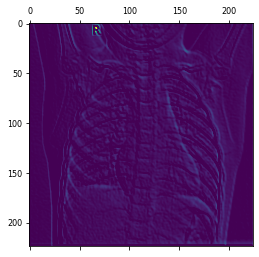

In [ ]:
plt.matshow(first_layer_activation[0,:,:,5], cmap='viridis')

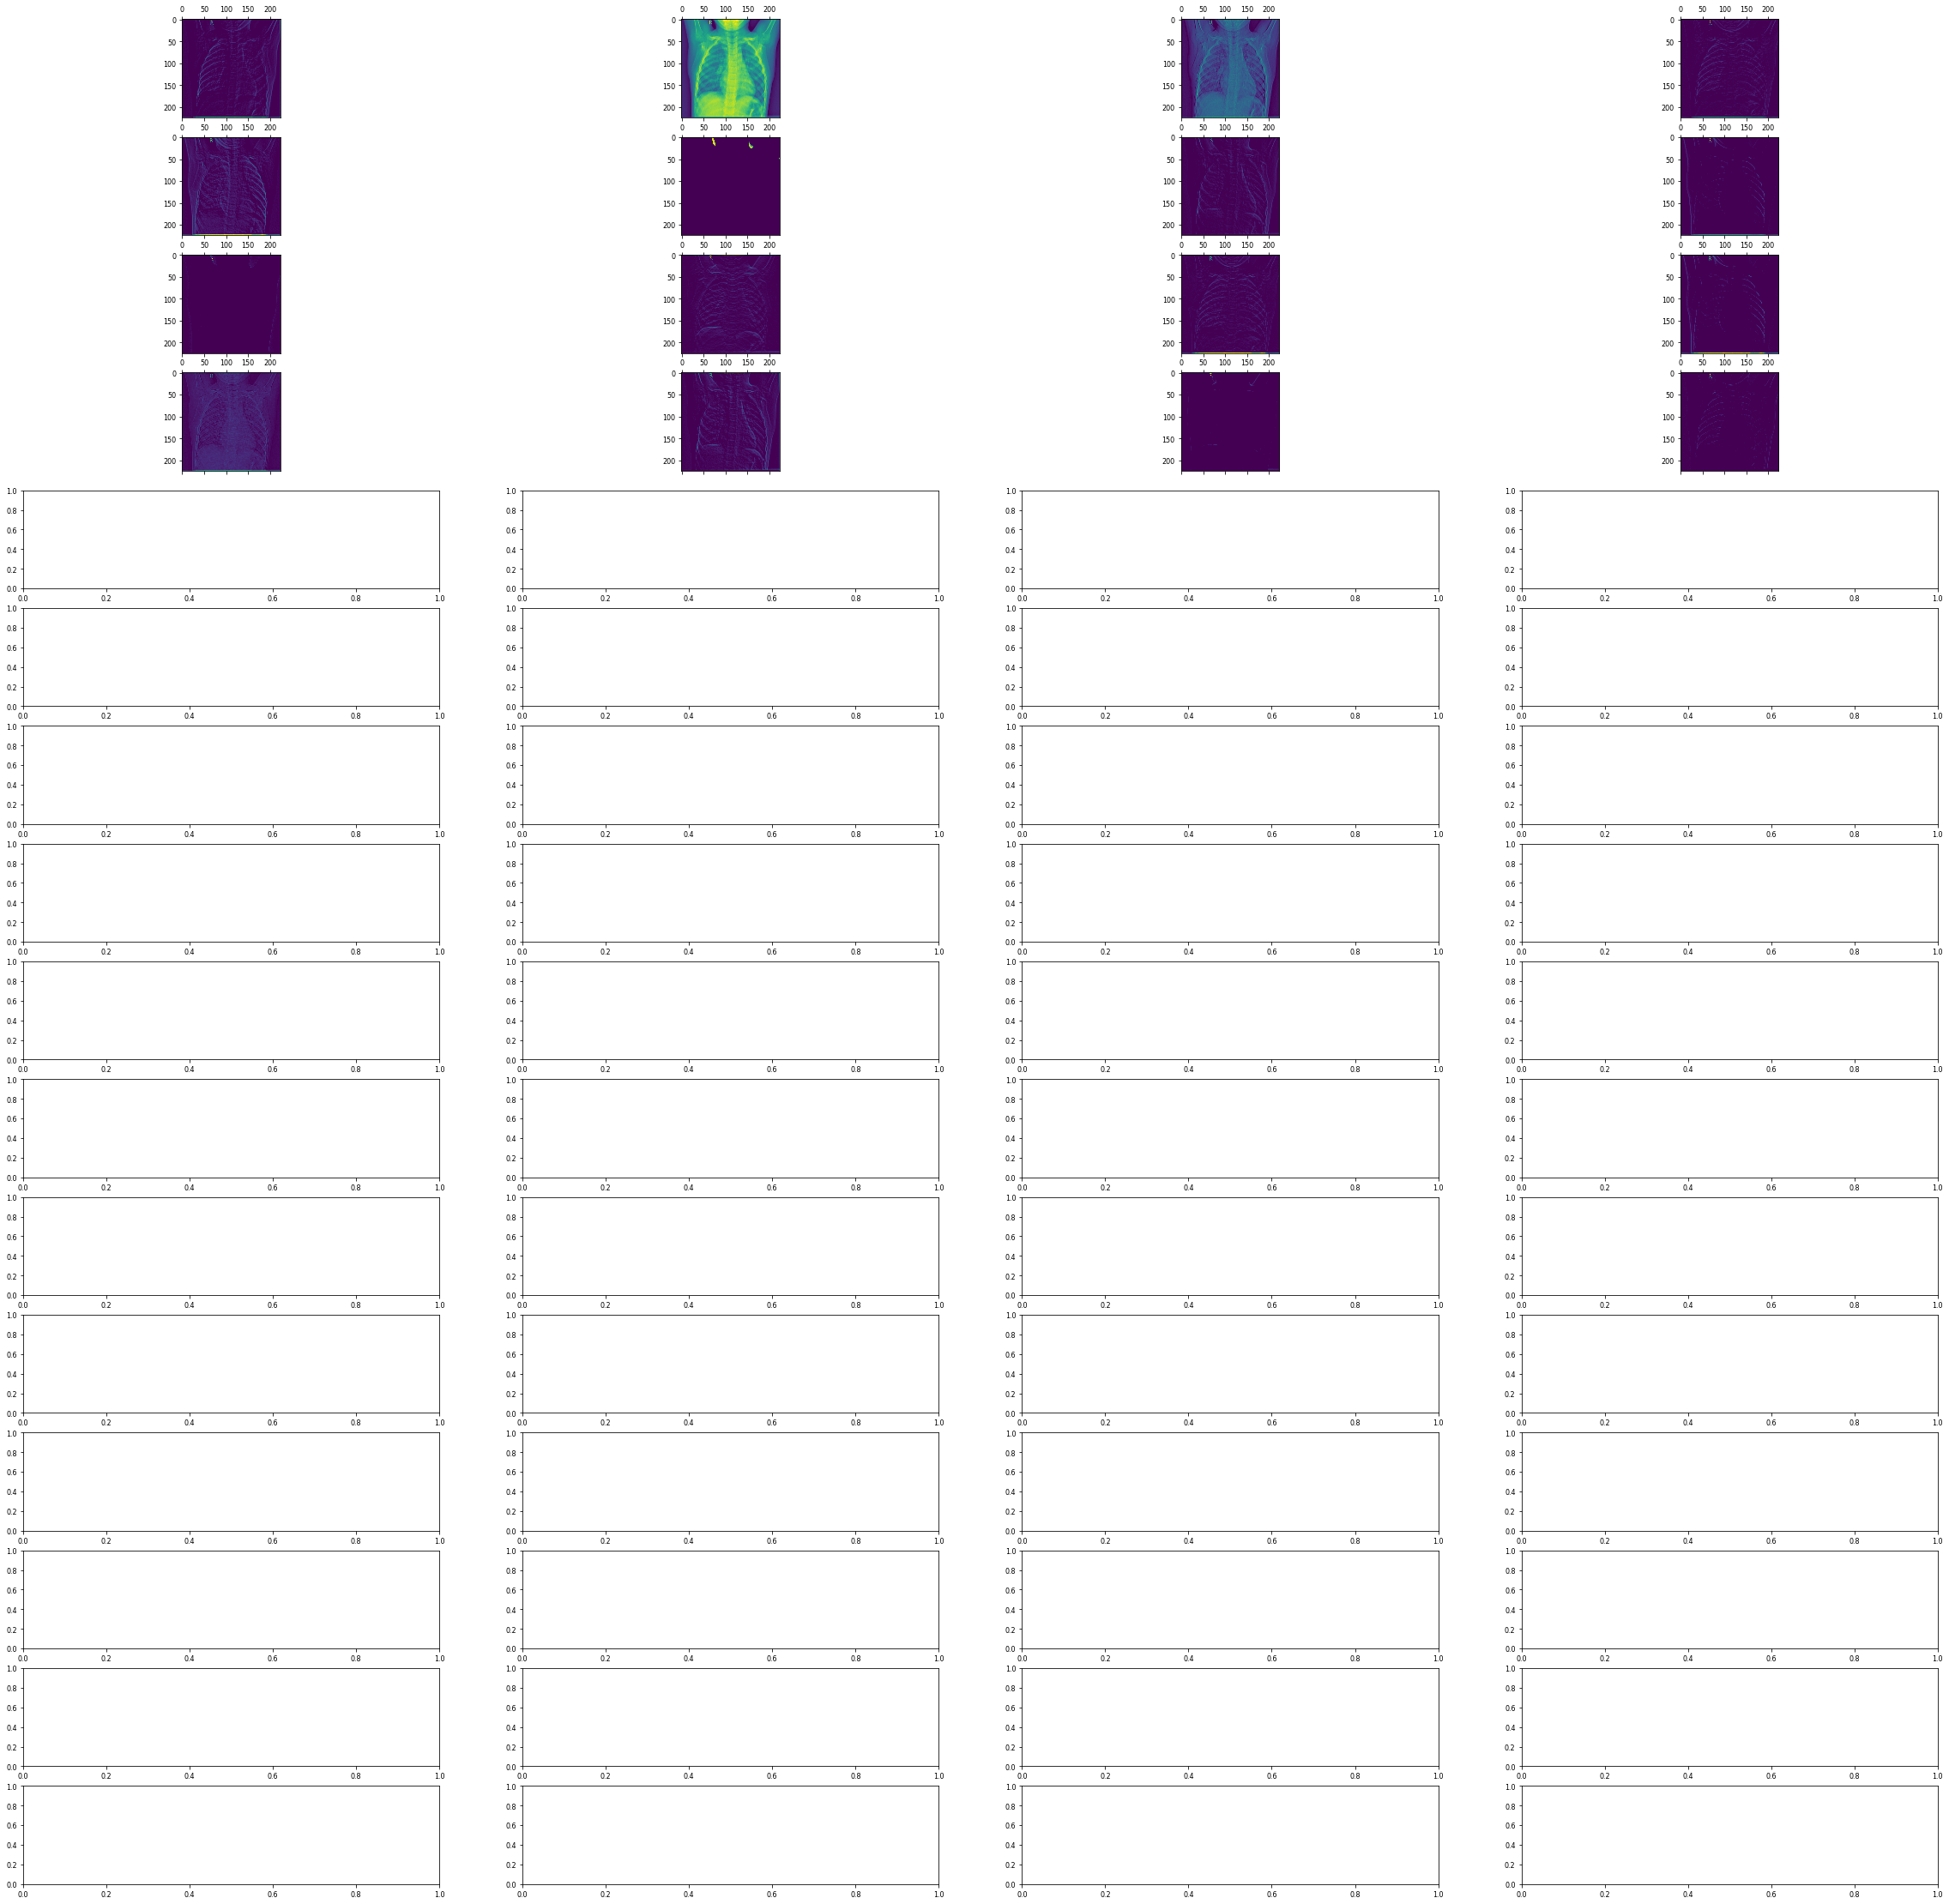

In [ ]:
for i in range(1,2):
  first_layer_activation = activations[i]
  x = first_layer_activation.shape[3]
  fig, ax = plt.subplots(int(x/4),4,figsize=(40,40))
  for j in range(int(x/4)):
    ax[int(j/4)][j%4].matshow(first_layer_activation[0,:,:,j], cmap='viridis')